
# Atlas-voting decision regions-scorer

Developed  by Frank Greco & Orest Xherja for analysing Atlas transcript data

## Synopsis
Three classifiers are initialized (`DecisionTreeClassifier`,
`KNeighborsClassifier`, and `SVC`) and used to initialize a
soft-voting `VotingClassifier` with weights [2, 1, 2].

A N-B classifier is trained using the NLTK-chat corpus to identify speech acts in text. 

The classifier is used to build a vector of speech acts for each transcript.

These vectors become training and test feature information which is fed to the above
classifiers, using the a specific tag present/not present vector as the label data.


In [1]:
#This may no longer be needed as we are not plotting...

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

## Imports

In [2]:
import sys
import os
#sys.path.append('/Users/fjgreco/Dev-Atlas')
#sys.path.insert(0, os.path.abspath(".."))

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
# Run this once

import json
import numpy as np

from itertools import product

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import collections

import dialogue_act as da


Create Speech Act Classifier
Accuracy
0.668


## External dependencies
dialgue_act.py depend on:
    nltk & nltk.corpus.nps_chat.xml_posts()
    frame_stack.py called by dialogue_act

text_dict5.json

Optional: X_tw08.p  contains the  2D tone analysis feature vectors for the transcripts

In [4]:
# Using a dictionary containing the transcript text, 
# returns a tf-idf matrix for the transcript corpus.

def tfidf(train_dict):

    print ("# retained documents:", len(train_dict))

    train_set = []

    #od = collections.OrderedDict(sorted(train_dict.items()))
    #for x in od.keys():
    #    train_set.append(od[x]['text'])
    
    for x in train_dict.keys():
        train_set.append(train_dict[x]['text'])

    vectorizer1 = HashingVectorizer()
    vectorizer2 = TfidfVectorizer(ngram_range=(1, 1))
    vectorizer3 = CountVectorizer()

    matrix_train1 = vectorizer1.fit_transform(train_set)  # finds the Hashing score with normalization
    cosine_scores1 = cosine_similarity(matrix_train1, matrix_train1)
    matrix_train2 = vectorizer2.fit_transform(train_set)  # finds the tfidf score with normalization
    cosine_scores2 = cosine_similarity(matrix_train2, matrix_train2)
    matrix_train3 = vectorizer3.fit_transform(train_set)  # finds the Count score with normalization
    cosine_scores3 = cosine_similarity(matrix_train3, matrix_train3)
    # [n:m] controls what document[s] are  compared to. Comparison values are stored as lists in a list.
    # [0:1] causes he first element of tfidf_matrix_train to me compared to the remaining elements.

    #for item in zip(doc_ids, doc_names,cosine_scores[0]):
    #   print (item)
    return matrix_train2.todense()

In [5]:
# Proxy routine that reads a pre-built json file containing a curated set of transcripts and associated 
# feature information. This json/dictionary approach was taken to minimized time consuming file I/O 
# and cloud based service interactions.   
def make_tfidf_vectors(text_dict='text_dict5.json'):
    import json
    
    print("Started. make_tfidf_vectors...")
    
    with open(text_dict) as data_file:
        text_dict = json.load(data_file)
        
    return tfidf(text_dict)

In [6]:
# Returns a vector (y) of class  labels, one for each transcript, indicating whether the input tag was assigned to
# the associated transcripts. (Each  transcript is associated with a y component that align
# aligns withe  a row featue vector in the X training matrix.)

def make_y_vectors(text_dict='text_dict5.json', tag='TWXX',limit=200):
    #print("Started make_y_vectors...")
    # Read JSON file
 
    count = 0

    with open(text_dict) as data_file:
        text_dict = json.load(data_file)

    y_pre=[]
    
    for key in text_dict.keys():

        count+= 1

        if tag in text_dict[key]['tags']:
            v = 1

        else:
            v = 0

        y_pre.append([v])

        if count == limit:
            break


    #print (len(y_pre))

    y = np.array(y_pre)


    return y.ravel(1)

In [7]:
# Using the N-B classifier, returns the speech act vector for each transript 

def make_sac_vectors(text_dict='text_dict5.json', limit=217):
    print("Started make_sac_vectors...")
    
    count = 0

    with open(text_dict) as data_file:
        text_dict = json.load(data_file)

    X_pre=[]

    for key in text_dict.keys():

        count+= 1

        #print ('Count: {}, key: {}'.format(count,key))


        #tone_r = tone_analyzer.tone(text_dict[key]['text'])

        sac= da.speech_act_vector(text_dict[key]['text'])
        
        
        #X_pre.append([tone_r["document_tone"]["tone_categories"][1]['tones'][0]["score"],
        #              tone_r["document_tone"]["tone_categories"][2]['tones'][4]["score"]])

        #print([sac[key2] for key2 in sac.keys()])

        X_pre.append([sac[key2] for key2 in sac.keys()])


        #print (json.dumps(tone_r,indent=2))

        if count == limit:
            break


    print (len(X_pre))


    #X = np.array(X_pre)
    flat_list=[item for sublist in X_pre for item in sublist]
    X_sac=np.array(flat_list).reshape((217,15))##

    return X_sac

## Build X (train/test) matrix; stack various feature vectors as desired

In [8]:

# Uncomment the following two lines to restore the "tone analysis" vector set.
# import pickle
# X_twa = pickle.load(open("X_tw08.p","rb"))

# Uncomment the following to generate a tf-idf vector set (vector)
X_tfidf=make_tfidf_vectors()


# The following generated the speech act vector set (matrix)
#X_sac = make_sac_vectors(limit=217)

# X iss picked up by the subsequent multi-method classifiers.
#X=X_sac
X=X_tfidf

# Pick and choice what features to incorporate
#X=np.hstack((X_tfidf,X_sac))
#X=np.hstack((X_twa,X_sac))
#X=X_twa

print(X)


Started. make_tfidf_vectors...
# retained documents: 217
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [9]:
# The main mult-classifier function...

def fit(X,y,tag,n_shuffles=5):
    print ('\n'+tag)
    
    score_totals=[0,0,0,0]
    split=100

    for j in range(n_shuffles):
        #print("\nRun:{}".format(j))
        # Training classifiers
        clf1 = DecisionTreeClassifier(max_depth=4)
        clf2 = KNeighborsClassifier(n_neighbors=7)
        clf3 = SVC(kernel='rbf', probability=True)
        eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                            ('svc', clf3)],
                                voting='soft', weights=[2, 1, 2])

        clf1.fit(X[:split], y[:split])
        clf2.fit(X[:split], y[:split])
        clf3.fit(X[:split], y[:split])
        eclf.fit(X[:split], y[:split])


        """
        # Plotting decision regions
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
        """                 


        for idx1, idx, clf, tt in zip([0,1,2,3],product([0, 1], [0, 1]),
                                [clf1, clf2, clf3, eclf],
                                ['Decision Tree (depth=4)', 'KNN (k=7)','Kernel SVM', 'Soft Voting']):

            clf.fit(X[:split],y[:split])
            Z=clf.predict(X[split:])
            score=accuracy_score(y[split:],Z)
            #print(clf.__class__.__name__,score)
            score_totals[idx1] += score

            #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) # Not apropos here

            #print ("Two (same) target predictions ===>")
            #print(clf.predict([[  0.00000000e+00 ,  1.00000000e+00 ,  3.47531000e-01  , 4.33134000e-01],[  0.00000000e+00 ,  1.00000000e+00  , 3.47531000e-01 ,  4.33134000e-01]]))



        X, y = shuffle(X, y, random_state=0)

    methods=['Decision Tree (depth=4)', 'KNN (k=7)','Kernel SVM', 'Soft Voting']
    
    for idx1, total in enumerate(score_totals):
        print ("idx:{} average score: {}".format(methods[idx1], total/n_shuffles))


In [10]:
# Calls the above classifier for each tag in the list. Within each instance, the data is 
# shuffled and the various classifiers are called ns times.

# special note: to print the accuray scores for each of the runs, uncomment the 
# appropriate print statments in the fit routine

ns=5  #number of shuffles
print('#shuffles:{}'.format(ns))
for tag in ['TW01','TW02','TW03','TW04','TW05','TW06','TW06s','TW07','TW08','TW09','TW09s',
           'TW10','TW11','TW13','TW15','TW16','TW17','TW18','TW19','TW20','TW22','TW23','TW24']:
    y=make_y_vectors(text_dict='text_dict5.json',tag=tag,limit=217)
    fit(X,y,tag,n_shuffles=ns)


#shuffles:5

TW01
idx:Decision Tree (depth=4) average score: 0.5487179487179488
idx:KNN (k=7) average score: 0.5282051282051282
idx:Kernel SVM average score: 0.505982905982906
idx:Soft Voting average score: 0.5401709401709403

TW02
idx:Decision Tree (depth=4) average score: 0.5401709401709403
idx:KNN (k=7) average score: 0.5606837606837607
idx:Kernel SVM average score: 0.5914529914529915
idx:Soft Voting average score: 0.5350427350427351

TW03
idx:Decision Tree (depth=4) average score: 0.8307692307692307
idx:KNN (k=7) average score: 0.9076923076923077
idx:Kernel SVM average score: 0.9076923076923077
idx:Soft Voting average score: 0.9008547008547009

TW04
idx:Decision Tree (depth=4) average score: 0.8547008547008547
idx:KNN (k=7) average score: 0.888888888888889
idx:Kernel SVM average score: 0.8905982905982907
idx:Soft Voting average score: 0.8803418803418804

TW05
idx:Decision Tree (depth=4) average score: 0.5538461538461539
idx:KNN (k=7) average score: 0.6564102564102564
idx:Kernel SVM

In [14]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
Y=y
# create model

model = Sequential()
model.add(Dense(217, input_dim=11435, activation='relu'))
model.add(Dense(11435, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X, Y, epochs=150, batch_size=10)
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
217/217 [==============================] - 2s - loss: 0.6123 - acc: 0.7143     
Epoch 2/150
217/217 [==============================] - 2s - loss: 0.3871 - acc: 0.7834     
Epoch 3/150
217/217 [==============================] - 2s - loss: 0.1061 - acc: 0.9954     
Epoch 4/150
217/217 [==============================] - 1s - loss: 0.0011 - acc: 1.0000     
Epoch 5/150
217/217 [==============================] - 2s - loss: 5.3966e-05 - acc: 1.0000     
Epoch 6/150
217/217 [==============================] - 2s - loss: 3.1745e-05 - acc: 1.0000     
Epoch 7/150
217/217 [==============================] - 2s - loss: 2.4871e-05 - acc: 1.0000     
Epoch 8/150
217/217 [==============================] - 2s - loss: 2.0772e-05 - acc: 1.0000     
Epoch 9/150
217/217 [==============================] - 2s - loss: 1.7441e-05 - acc: 1.0000     
Epoch 10/150
217/217 [==============================] - 2s - loss: 1.4615e-05 - acc: 1.0000     
Epoch 11/150
217/217 [==============================] -

217/217 [==============================] - 2s - loss: 2.7241e-07 - acc: 1.0000     
Epoch 86/150
217/217 [==============================] - 2s - loss: 2.6817e-07 - acc: 1.0000     
Epoch 87/150
217/217 [==============================] - 2s - loss: 2.6340e-07 - acc: 1.0000     
Epoch 88/150
217/217 [==============================] - 1s - loss: 2.5825e-07 - acc: 1.0000     
Epoch 89/150
217/217 [==============================] - 1s - loss: 2.5401e-07 - acc: 1.0000     
Epoch 90/150
217/217 [==============================] - 2s - loss: 2.5078e-07 - acc: 1.0000     
Epoch 91/150
217/217 [==============================] - 2s - loss: 2.4584e-07 - acc: 1.0000     
Epoch 92/150
217/217 [==============================] - 2s - loss: 2.4349e-07 - acc: 1.0000     
Epoch 93/150
217/217 [==============================] - 2s - loss: 2.3946e-07 - acc: 1.0000     
Epoch 94/150
217/217 [==============================] - 2s - loss: 2.3651e-07 - acc: 1.0000     
Epoch 95/150
217/217 [=====================

In [33]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import pickle
#import data
#from my_metrics import my_me
import keras.backend as K

def my_me(y_true, y_pred):
            return K.std(y_true-y_pred)

#N = 10000
epochs = 10

#d = data.data(size=N, f = lambda x: (x-1)**3, left=-2, right=2, amplitude=1.0)
#((x_train,y_train),(x_validation,y_validation),(x_test,y_test)) = d.compute_tvt(split=(0.9, 0.05))

split=100
x_train=X[:split]
y_train=y[:split]
x_validation=X[split:]
y_validation=y[split:]

x_test=x_validation
y_test=y_validation


f=open("output/test.pickle","wb")
pickle.dump((x_test,y_test),f)
f.close()

inputs = Input(shape=(11435,))
x = Dense(100, activation='relu')(inputs)
predictions = Dense(1)(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='sgd', loss='mse', metrics=[my_me])

h  = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=50,
               callbacks=[ModelCheckpoint('output/best_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)])

model.save("output/final.h5")

f=open("output/history.pickle","wb")
pickle.dump((h.history,h.params), f)
f.close()



Train on 100 samples, validate on 117 samples
Epoch 1/10
100/100 [==============================] - 0s - loss: 0.2343 - my_me: 0.4265 - val_loss: 0.3091 - val_my_me: 0.4615
Epoch 2/10
100/100 [==============================] - 0s - loss: 0.2270 - my_me: 0.4264 - val_loss: 0.3004 - val_my_me: 0.4615
Epoch 3/10
100/100 [==============================] - 0s - loss: 0.2209 - my_me: 0.4211 - val_loss: 0.2927 - val_my_me: 0.4616
Epoch 4/10
100/100 [==============================] - 0s - loss: 0.2155 - my_me: 0.4244 - val_loss: 0.2858 - val_my_me: 0.4616
Epoch 5/10
100/100 [==============================] - 0s - loss: 0.2107 - my_me: 0.4269 - val_loss: 0.2797 - val_my_me: 0.4617
Epoch 6/10
100/100 [==============================] - 0s - loss: 0.2068 - my_me: 0.4209 - val_loss: 0.2741 - val_my_me: 0.4617
Epoch 7/10
100/100 [==============================] - 0s - loss: 0.2033 - my_me: 0.4162 - val_loss: 0.2691 - val_my_me: 0.4616
Epoch 8/10
100/100 [==============================] - 0s - loss: 

ValueError: width and height must each be below 32768

history= {'my_me': [0.42647728323936462, 0.42643144726753235, 0.42110142111778259, 0.42441146075725555, 0.42688445746898651, 0.4209379106760025, 0.41615988314151764, 0.42587646842002869, 0.42577411234378815, 0.4206186980009079], 'val_loss': [0.30912303746256053, 0.30039007796181572, 0.2927063925144, 0.2857958412068522, 0.27966294507695061, 0.27411788447290403, 0.26914545078562874, 0.26476469304826522, 0.26087496627090323, 0.25747412545049292], 'loss': [0.23425565659999847, 0.22703386098146439, 0.22091247886419296, 0.21547913551330566, 0.21073631942272186, 0.20678313821554184, 0.20331599563360214, 0.19995366781949997, 0.19729053229093552, 0.19512647390365601], 'val_my_me': [0.46146092302778846, 0.46153898575367069, 0.46159985228481454, 0.46164680011252052, 0.46167094126725811, 0.46166350698878622, 0.46163664516220743, 0.46161106075996006, 0.46158776553268105, 0.4615866911207509]}
params= {'epochs': 10, 'metrics': ['loss', 'my_me', 'val_loss', 'val_my_me'], 'do_validation': True, 'batch_

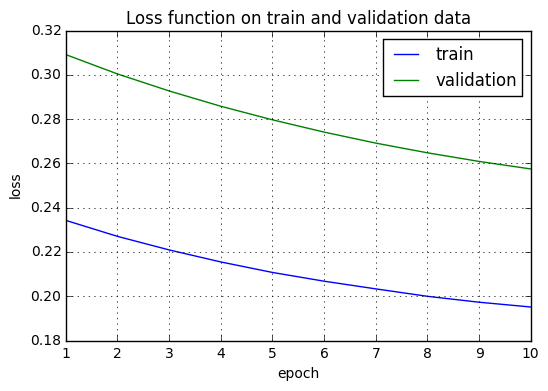

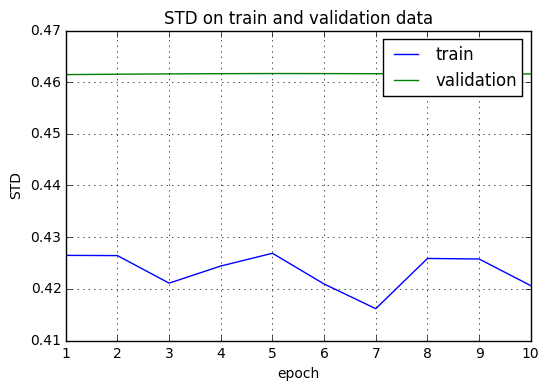

model summary=
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 11435)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1143600   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 1,143,701
Trainable params: 1,143,701
Non-trainable params: 0
_________________________________________________________________
model to_json= {"config": {"output_layers": [["dense_20", 0, 0]], "name": "model_7", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 11435], "sparse": false, "name": "input_7", "dtype": "float32"}, "name": "input_7", "inbound_nodes": []}, {"class_name": "Dense", "config": {"bias_constraint": null, "units": 100, "kernel_constraint": null, "use_bias"

In [34]:
from keras.models import load_model
import pickle
import matplotlib as mpl 
mpl.use('Agg')
import matplotlib.pyplot as plt
#from my_metrics import my_me
import numpy as np

model = load_model("output/best_checkpoint.h5", custom_objects={"my_me":my_me})

x_test, y_test = pickle.load(open("output/test.pickle","rb"))
y_test_predict = model.predict(x_test)
plt.plot(x_test, y_test, 'bo', label = "measurements")
plt.plot(x_test, y_test_predict, 'r+', label = "predictions")
plt.title("Prediction vs measurements on test data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("output/prediction.png")
plt.show()
plt.clf()

history, params  = pickle.load(open("output/history.pickle","rb"))
print("history=",history)
print("="*50)
print("params=",params)
print("="*50)

plt.plot(range(1, params['epochs']+1), history['loss'], label="train")
plt.plot(range(1, params['epochs']+1), history['val_loss'], label="validation")
plt.legend()
plt.title("Loss function on train and validation data")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.savefig("output/loss.png")
plt.show()
plt.clf()

plt.plot(range(1, params['epochs']+1), history['my_me'], label="train")
plt.plot(range(1, params['epochs']+1), history['val_my_me'], label="validation")
plt.legend()
plt.title("STD on train and validation data")
plt.xlabel("epoch")
plt.ylabel("STD")
plt.grid(True)
plt.savefig("output/std.png")
plt.show()
plt.clf()

print("model summary=")
model.summary()
print("="*50)
print("model to_json=",model.to_json())
print("="*50)

from keras.utils import plot_model
plot_model(model, to_file='output/model.png', show_shapes=True)
